# Vowel Overlap Analysis
We'd like to investigate whether model substitution errors for vowel are related to the overlap between vowels according to the Pillai scores. We'll run correlations comparing the substitution rate between an original vowel _v_ and a substitution _w_ with the Pillai score of _v,w_. 
We'll do this analysis for a single AutoIPA model, but in two settings: 
- Within Buckeye: Comparing substitution rates on the Buckeye test set to Pillai scores computed on the Buckeye corpus
- On TIMIT: Comparing substitution rates on the TIMIT corpus to Pillai scores that compare TIMIT vowels to Buckeye vowels
- 


In [1]:
from collections import Counter, defaultdict
from pathlib import Path
from typing import Iterable

import ipatok
import kaldialign
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats

sns.color_palette("colorblind")
font = {"size": 16}
matplotlib.rc("font", **font)
# Remove the limits on the number of rows displayed in the notebook
pd.options.display.max_rows = None


In [2]:
TIMIT_VOWELS = ["ɑ", "æ", "ʌ", "ɔ", "ɛ", "ɪ", "i", "ʊ", "u", "ə", "ə̥", "ʉ", "ɨ", "ɝ"]
TIMIT_DIPHTHONGS = ["aʊ", "eɪ", "aɪ", "oʊ", "ɔɪ"]

# This doesn't include all the nasalized vowels, only the ones that we computed the Pillai scores for
BUCKEYE_VOWELS = ["æ", "æ̃", "i", "u", "ĩ", "ɑ", "ɔ", "ɛ", "ɪ", "ʊ", "ʌ", "ɑ̃", "ɛ̃","ɪ̃", "ɹ̩", "ʌ̃", "ũ"]
# Includes all diphthongs, including nasalized, just to make tokenization and counts consistent
BUCKEYE_DIPHTHONGS = ["eɪ", "oʊ", "aʊ", "aɪ", "ɔɪ", "ẽɪ̃", "õʊ̃", "ãɪ̃", "ãʊ̃", "ɔ̃ɪ̃"]

BUCKEYE_TRANSCRIPTIONS = Path(
    "../../data/evaluation_results/detailed_predictions/ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv"
)
WITHIN_BUCKEYE_PILLAI_CSV = Path("./pillai_scores_within_buckeye.csv")


TIMIT_GOLD_TRANSCRIPTIONS = Path("../../data/TIMIT Dataset/complete_ipa.csv")
TIMIT_MODEL_PREDICTIONS = Path(
    "../../data/timit_results/detailed_predictions/ginic_full_dataset_train_3_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv"
)
TIMIT_VS_BUCKEYE_PILLAI = Path("./pillai_scores_buckeye_timit.csv")

In [23]:
# Sets up reusable functions for tokenization and substitution calculations

EPS = "***"

def tally_edit_distance_errors(references, predictions):
    """Counts up edit distances from lists of already tokenized references and predictions."""
    subs = Counter()
    insertions = Counter()
    deletions = Counter()
    for ref_tokens, pred_tokens in zip(references, predictions):
        aligned_pairs = kaldialign.align(ref_tokens, pred_tokens, EPS)

        for r, p in aligned_pairs:
            if r == EPS:
                insertions[p] += 1
            elif p == EPS:
                deletions[r] += 1
            elif r != p:
                subs[(r, p)] += 1

    return subs, deletions, insertions


def diphthong_merge(t1, t2, dipthongs):
    """For merge detected diphthongs in predicted output when using ipatok.tokenise"""
    if t1 + t2 in dipthongs:
        return True
    else:
        return False

# Use for Buckeye tokenization for convenience
buckeye_merge_func = lambda x,y: diphthong_merge(x, y, BUCKEYE_DIPHTHONGS)

# Use for TIMIT tokenization for convenience
timit_merge_func = lambda x, y: diphthong_merge(x, y, TIMIT_DIPHTHONGS)


def get_substitution_counts_as_dataframe(substitutions: Counter[tuple]):
    """Converts the substition counter to a DataFrame"""
    return pd.DataFrame([(t[0], t[1], count) for t, count in substitutions.items()], columns=["original", "substitution", "substitution_count"])

def get_total_token_counts(token_lists:Iterable[list[str]]):
    """Count up tokens and return the results as a dataframe"""
    token_counter = Counter()
    for tokens in token_lists:
        token_counter.update(tokens)
    return token_counter, pd.DataFrame(token_counter.items(), columns=["phone", "total_count"])


def get_normalized_substitution_counts_df(substitutions_df, token_counts_df,
                                  substitution_join_key = "original",substitution_count_key="substitution_count", total_counts_join_key="phone", total_counts_count_key="total_count"):
    """Given a DataFrame of phone substitutions and a DataFrame of phone counts, join them and compute normalized substitution
    error rates.
    Returns the joined dataframe with a "normalized_substitution_rate".
    """
    joined_df = pd.merge(substitutions_df, token_counts_df, left_on=substitution_join_key, right_on=total_counts_join_key)
    joined_df["normalized_substitution_rate"] = joined_df[substitution_count_key] / joined_df[total_counts_count_key]
    return joined_df

def get_error_rates_with_deletions(subs_counter, del_counter, overall_counts, desired_tokens):
    err_rate = {}
    for token in desired_tokens:
        if token in overall_counts:
            subs_count = subs_counter[token]
            dels_count = del_counter[token]
            ver = (subs_count + dels_count) / (overall_counts[token])
            err_rate[token] = ver
        else:
            print(f"Warning: '{token}' not in Buckeye test corpus gold standard transcriptions")

    return err_rate

def compute_error_rate_confidence_intervals_df(error_rate_df, count_df, error_rate_join_key, count_join_key, error_rate_col, count_col, interval_const = 1.96):
    """Computes error rates for each vowel with a confidence interval of according to
    https://machinelearningmastery.com/report-classifier-performance-confidence-intervals/
    The default settings give a confidence interval of 95%.
    """
    joined_df = pd.merge(error_rate_df, count_df, left_on=error_rate_join_key, right_on=count_join_key, how="inner")
    error_series = joined_df[error_rate_col]
    joined_df["confidence_interval"] = interval_const * np.sqrt( (error_series *(1-error_series))/ joined_df[count_col])
    return joined_df


def plot_error_rate_heat_map(err_rate_df, title, key="Vowel Error Rate", index="Vowel", cmap_palette="rainbow", vmin=0, vmax=None, annot=True, fmt = ".2f") -> None:
    """Plots error rates/frequency for vowels (or whatever desired token) as a heatmap"""
    plot_df = err_rate_df.sort_values(by=key, ascending=False).set_index(index)
    plt.figure(figsize=(4, 6))
    sns.heatmap(
        plot_df,
        cmap=cmap_palette,
        # cmap="spring_r",
        annot=annot,
        fmt=fmt,
        # linewidths=1,
        vmin=vmin, vmax=vmax, # Alow tweaking lower and upper bounds
        yticklabels=plot_df.index # label everything
    )
    plt.title(title)
    plt.yticks(rotation=0)
    plt.ylabel("")
    plt.show()

def join_substitutions_errors_and_pillai_scores(substitutions_df, pillai_df,
                                                    pillai_vowel1_key, pillai_vowel2_key,
                                                    substitutions_orig_key = "original", substitutions_sub_key = "substitution"):
    # First match: original=vowel1 AND substitution=vowel2
    result1 = pd.merge(
        substitutions_df,
        pillai_df,
        left_on=[substitutions_orig_key, substitutions_sub_key],
        right_on=[pillai_vowel1_key, pillai_vowel2_key],
        how="inner"  # Only get matches for this condition
    )

    # Second match: original=vowel2 AND substitution=vowel2
    result2 = pd.merge(
        substitutions_df,
        pillai_df,
        left_on=[substitutions_orig_key, substitutions_sub_key],
        right_on=[pillai_vowel2_key, pillai_vowel1_key],
        how="inner",  # Only get matches for this condition
    )

    # Combine successful matches from both conditions
    matched_results = pd.concat([result1, result2]).drop_duplicates()
    return matched_results

def plot_pillai_substitution_rate_relationship_scatter(joined_df, plot_title, pearsons_position,  pillai_col="Pillai", nsr_col="normalized_substitution_rate", xlim=None, ylim=None, ):
    pearson_r = scipy.stats.pearsonr(
            joined_df["Pillai"], joined_df["normalized_substitution_rate"]
        )
    print(pearson_r)
    g = sns.scatterplot(data=joined_df, x=nsr_col, y=pillai_col)
    plt.xlabel("Normalized rate of $\it{v}$ substituted by $\it{w}$")
    plt.ylabel("Pillai score of $\it{v, w}$")
    g.annotate("Pearson r: {:.2f}".format(pearson_r[0]), xy=pearsons_position)
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)
    plt.title(plot_title, y=1.05)


def plot_pillai_substitution_rate_relationship_heatmap(joined_df, plot_title, pillai_col="Pillai", nsr_col="normalized_substitution_rate"):
    combined_long = pd.melt(
            joined_df,
            id_vars=["original", "substitution"],
            value_vars=[nsr_col, pillai_col],
            var_name="measure",
            value_name="value",
        )


    # Make measure names nicer
    measure_names = {nsr_col: "Normalized Substitution Rate", pillai_col: "Pillai"}
    combined_long["measure"] = combined_long["measure"].map(measure_names)


    # Custom plotting function for the heatmaps
    def plot_heatmap(data, **kwargs):
        # Create a pivot table for just this facet's data
        pivot_data = data.pivot(index="original", columns="substitution", values="value")

        # Create the mask for upper triangular region
        mask = np.triu(np.ones_like(pivot_data, dtype=bool))

        ax = sns.heatmap(pivot_data, mask=mask, vmin=0, vmax=1, yticklabels=True, **kwargs)
        ax.set(xlabel="substituted vowel", ylabel="original vowel")


    # Create the FacetGrid
    fig = plt.figure(figsize=(16, 7))
    g = sns.FacetGrid(combined_long, col="measure", height=6, aspect=1)
    g.map_dataframe(plot_heatmap, cmap="rainbow")
    g.set_titles(col_template="{col_name}")
    g.tight_layout()
    g.figure.suptitle(plot_title, y=1.05)
    plt.show()

## Within Buckeye Comparison

In [4]:
# Read in data, tokenize phones and get edit distance errors
buckeye_results_df = pd.read_csv(BUCKEYE_TRANSCRIPTIONS)

for (in_col, out_col) in [("ipa", "ipa_tokens"), ("prediction", "prediction_tokens")]:
    buckeye_results_df[out_col] = buckeye_results_df[in_col].apply(lambda x: ipatok.tokenise(str(x), diphthongs=True, merge=buckeye_merge_func))

buckeye_results_df.head()

,utterance_id,duration,buckeye_transcript,text,ipa,speaker_id,speaker_gender,speaker_age_range,interviewer_gender,file_path,prediction,phone_error_rates,phone_feature_error_rates,feature_error_rates,deletions,insertions,substitutions,ipa_tokens,prediction_tokens
0,s2501a_Utt0,0.925981,f ao r f ay v,four five,fɔɹfaɪv,S25,f,o,m,data/buckeye/test/s2501a_Utt0.wav,fɔɹɹ̩faɪv,0.142857,1.000000,0.264881,{},{'ɹ̩': 1},{},"[f, ɔ, ɹ, f, aɪ, v]","[f, ɔ, ɹ, ɹ̩, f, aɪ, v]"
1,s2501a_Utt1,13.394466,U uw ah nx ay hh ey tq hh iy r ih n m ay s eh ...,EXCLUDE-four_five_six_seven_eight_nine_ten_ele...,uʌɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑn,S25,f,o,m,data/buckeye/test/s2501a_Utt1.wav,uɛɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑnt,0.086957,1.083333,0.003623,{},{'t': 1},"{('ʌ', 'ɛ'): 1}","[u, ʌ, ɾ̃, aɪ, h, eɪ, ʔ, h, i, ɹ, ɪ, n, m, aɪ,...","[u, ɛ, ɾ̃, aɪ, h, eɪ, ʔ, h, i, ɹ, ɪ, n, m, aɪ,..."
2,s2501a_Utt2,22.609051,ah k ey U ah m ay tq w aa n n ah ch r ay dx uh...,okay VOCNOISE i might want to try to adjust th...,ʌkeɪʌmaɪʔwɑnnʌtʃɹaɪɾʊɪdʒʌssɪsʌlɪɾl̩bɪɾɪɡɛnɪfjʌ...,S25,f,o,m,data/buckeye/test/s2501a_Utt2.wav,aɪkeɪmaɪʔwɑnʌtʃɹaɪdʌdʒɛsɪsʌɾisɪɡoʊzʌnɹ̩ɹæiʌste...,0.605263,28.875000,0.169956,"{'ʌ': 2, 'n': 3, 'ɪ': 6, 's': 1, 'l': 2, 'b': ...","{'ɪ': 1, 'ʊ': 1}","{('ʌ', 'a'): 1, ('ɾ', 'd'): 1, ('ʊ', 'ʌ'): 1, ...","[ʌ, k, eɪ, ʌ, m, aɪ, ʔ, w, ɑ, n, n, ʌ, t, ʃ, ɹ...","[aɪ, k, eɪ, m, aɪ, ʔ, w, ɑ, n, ʌ, t, ʃ, ɹ, aɪ,..."
3,s2501a_Utt3,2.279839,n aa t U ih tq ah z b eh dx er b ih f ao r,not LAUGH it was better before,nɑtɪʔʌzbɛɾɹ̩bɪfɔɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt3.wav,nɑʔɪʔʌzbɛɾɹ̩bɪfɔɹ,0.062500,0.250000,0.014323,{},{},"{('t', 'ʔ'): 1}","[n, ɑ, t, ɪ, ʔ, ʌ, z, b, ɛ, ɾ, ɹ̩, b, ɪ, f, ɔ, ɹ]","[n, ɑ, ʔ, ɪ, ʔ, ʌ, z, b, ɛ, ɾ, ɹ̩, b, ɪ, f, ɔ, ɹ]"
4,s2501a_Utt4,0.410576,dh eh r,there,ðɛɹ,S25,f,o,m,data/buckeye/test/s2501a_Utt4.wav,ðɛɹ,0.000000,0.000000,0.000000,{},{},{},"[ð, ɛ, ɹ]","[ð, ɛ, ɹ]"


In [5]:
buckeye_subs, buckeye_dels, _ = tally_edit_distance_errors(buckeye_results_df["ipa_tokens"], buckeye_results_df["prediction_tokens"])
buckeye_subs_df = get_substitution_counts_as_dataframe(buckeye_subs)

buckeye_dels_df = pd.DataFrame(list(buckeye_dels.items()), columns=["deleted", "count"])

# Filter to just vowels
buckeye_subs_df = buckeye_subs_df[buckeye_subs_df["original"].isin(BUCKEYE_VOWELS + BUCKEYE_DIPHTHONGS)]
buckeye_dels_df = buckeye_dels_df[buckeye_dels_df["deleted"].isin(BUCKEYE_VOWELS + BUCKEYE_DIPHTHONGS)]
display(buckeye_subs_df.head())
display(buckeye_dels_df.head())


,original,substitution,substitution_count
0,ʌ,ɛ,474
1,ʌ,aɪ,93
3,ʊ,ʌ,199
5,u,oʊ,5
7,aɪ,æ,31


,deleted,count
0,ʌ,1033
2,ɪ,860
8,ɛ,307
11,eɪ,89
19,aɪ,143


In [6]:
buckeye_overall_substitutions = buckeye_subs_df.groupby("original")["substitution_count"].sum().reset_index()
display(buckeye_overall_substitutions)

,original,substitution_count
0,aɪ,599
1,aʊ,228
2,eɪ,382
3,i,878
4,oʊ,885
5,u,403
6,æ,612
7,æ̃,48
8,ɑ,470
9,ɑ̃,28


In [7]:
buckeye_token_counts, buckeye_token_counts_df = get_total_token_counts(buckeye_results_df["ipa_tokens"])
display(buckeye_token_counts_df.head())

,phone,total_count
0,f,2348
1,ɔ,1720
2,ɹ,6185
3,aɪ,4201
4,v,2329


In [8]:
# Compute and plot error rates considering both substitutions and deletions
buckeye_vowel_error_rates = get_error_rates_with_deletions(
    buckeye_subs, buckeye_dels, buckeye_token_counts, BUCKEYE_VOWELS + BUCKEYE_DIPHTHONGS
)
buckeye_ver_df = pd.DataFrame(buckeye_vowel_error_rates.items(), columns=["Vowel", "Vowel Error Rate"]).sort_values("Vowel Error Rate", ascending=False)
display(buckeye_ver_df)


,Vowel,Vowel Error Rate
12,ɪ̃,0.166667
14,ʌ̃,0.123596
11,ɛ̃,0.111111
8,ʊ,0.078341
9,ʌ,0.071355
7,ɪ,0.069171
3,u,0.053763
16,oʊ,0.048310
6,ɛ,0.044955
2,i,0.039813


In [9]:

# Confidence intervals for error rate
buckeye_full_err_rate_analysis= compute_error_rate_confidence_intervals_df(buckeye_ver_df, buckeye_token_counts_df, "Vowel", "phone", "Vowel Error Rate", "total_count").sort_values("Vowel Error Rate", ascending=False)
display(buckeye_full_err_rate_analysis)


,Vowel,Vowel Error Rate,phone,total_count,confidence_interval
0,ɪ̃,0.166667,ɪ̃,102,0.072325
1,ʌ̃,0.123596,ʌ̃,89,0.068378
2,ɛ̃,0.111111,ɛ̃,72,0.072593
3,ʊ,0.078341,ʊ,1085,0.015989
4,ʌ,0.071355,ʌ,14477,0.004193
5,ɪ,0.069171,ɪ,12433,0.004460
6,u,0.053763,u,2325,0.009168
7,oʊ,0.048310,oʊ,3788,0.006828
8,ɛ,0.044955,ɛ,6829,0.004915
9,i,0.039813,i,6631,0.004706


In [10]:
buckeye_normalized_substitution_rates = get_normalized_substitution_counts_df(buckeye_subs_df, buckeye_token_counts_df).sort_values(by=["original", "normalized_substitution_rate"], ascending=[True, False])
display(buckeye_normalized_substitution_rates.head())

,original,substitution,substitution_count,phone,total_count,normalized_substitution_rate
111,aɪ,ɑ,225,aɪ,4201,0.053559
109,aɪ,ʌ,179,aɪ,4201,0.042609
112,aɪ,ɛ,67,aɪ,4201,0.015949
106,aɪ,æ,31,aɪ,4201,0.007379
114,aɪ,eɪ,22,aɪ,4201,0.005237


In [11]:
# Read and join in Pillai scores with substitutions
buckeye_pillai_df = pd.read_csv(WITHIN_BUCKEYE_PILLAI_CSV)
buckeye_pillai_df.head()

buckeye_subs_pillai_df = join_substitutions_errors_and_pillai_scores(
    buckeye_normalized_substitution_rates, buckeye_pillai_df, "Vowel1", "Vowel2"
)
buckeye_subs_pillai_df.to_csv("buckeye_pillai_subs.csv")
display(buckeye_subs_pillai_df.head())


,original,substitution,substitution_count,phone,total_count,normalized_substitution_rate,Vowel1,Vowel2,Df,Pillai,approx F,num Df,den Df,Pr(>F),Vowel1_Count,Vowel2_Count,Total_Count
0,eɪ,ɪ,69,eɪ,3035,0.022735,eɪ,ɪ,1,0.047209,1139.875312,2,46011,0.000000e+00,10313,35701,46014
1,eɪ,æ,20,eɪ,3035,0.006590,eɪ,æ,1,0.432168,6750.820056,2,17740,0.000000e+00,10313,7430,17743
2,eɪ,u,2,eɪ,3035,0.000659,eɪ,u,1,0.164685,1722.824409,2,17477,0.000000e+00,10313,7167,17480
3,eɪ,ɑ,1,eɪ,3035,0.000329,eɪ,ɑ,1,0.756085,28600.176567,2,18453,0.000000e+00,10313,8143,18456
4,eɪ,æ̃,1,eɪ,3035,0.000329,eɪ,æ̃,1,0.009435,50.574325,2,10619,1.379740e-22,10313,309,10622


PearsonRResult(statistic=-0.28955972362130505, pvalue=0.00015438119460526426)


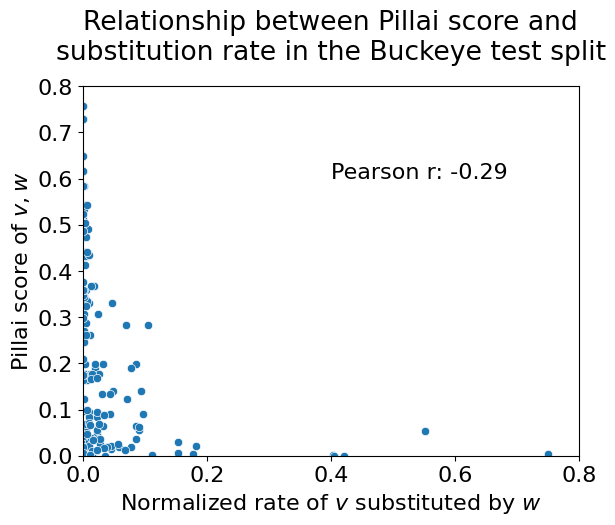

In [20]:
plot_pillai_substitution_rate_relationship_scatter(buckeye_subs_pillai_df, "Relationship between Pillai score and\nsubstitution rate in the Buckeye test split", pearsons_position=(0.4, 0.6), xlim=(0, 0.8), ylim=(0,0.8))

<Figure size 1600x700 with 0 Axes>

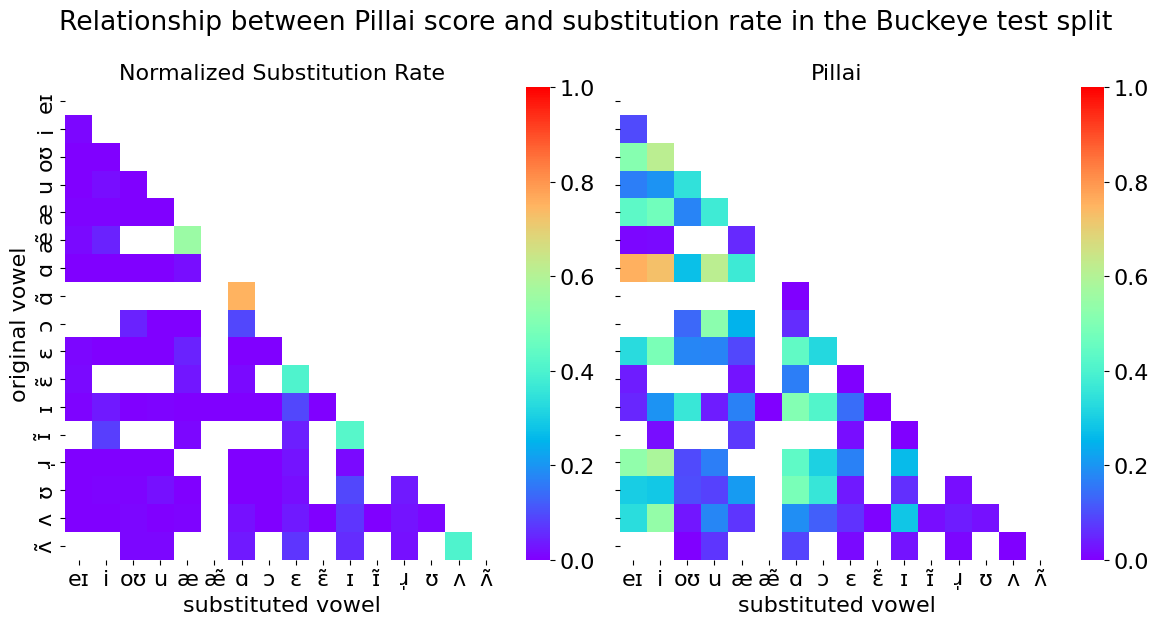

In [24]:
plot_pillai_substitution_rate_relationship_heatmap(buckeye_subs_pillai_df, "Relationship between Pillai score and substitution rate in the Buckeye test split")